# Test cases to convert arbitrary flux values into hourly values

In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

### Functions

In [2]:
# Fill gaps with temporary values where needed
def fill_data_gaps_on_integration_bounds(df, data='data', center_window=True):
    
    for ix,(time,row) in enumerate(df.iterrows()):

        # Missing value at a given point in time
        if np.isnan(row[data]): 

            # Only proceed if this is a timestamp that we'll need as a boundary value for volume integration
            if ((center_window) & (time.minute == 30)) or \
            ((not center_window)& (time.minute == 0)):

                # Check if we have any valid values in the past and/or next hour
                prev_time_mask = slice(time - timedelta(hours=1),time) # Returns empty series if time slice is out of index range
                prev_data_mask = (df[data].loc[prev_time_mask] >= 0) & \
                                 (df['is_obs'].loc[prev_time_mask]) # Has data and is observation (i.e. not previously filled value)
                next_time_mask = slice(time, time + timedelta(hours=1))
                next_data_mask = (df[data].loc[next_time_mask] >= 0) & \
                                 (df['is_obs'].loc[next_time_mask])

                # Select the correct case
                if any(prev_data_mask) and any(next_data_mask):
                    # do nothing: we'll interpolate the missing value later
                    continue # to next row in the dataframe
                elif any(prev_data_mask):
                    # Copy closest value from the previous hour into this position
                    df.at[time,data] = df[prev_time_mask][prev_data_mask].iloc[-1][data]
                elif any(next_data_mask):
                    # Copy the closest value from the next hour into this position
                    df.at[time,data] = df[next_time_mask][next_data_mask].iloc[-1][data]
                else:
                    # do nothing: we don't have observations from either the previous or the next hour, so we'll leave this empty
                    continue # to next row in the dataframe
    
    return df

In [3]:
def resample_arbitrary_flux_observations_to_hourly(df, data='data', center_window=True, keep_tmp_col=False):
    
    '''Takes a dataframe with a timestamp index and a "data" column and returns old and new dataframe with hourly data values'''
    
    # Inputs:
    # df            - dataframe with a column with name [data]
    # data          - column name; default 'data'
    # center_window - flag to state if hourly resampling should take the whole hour as the mid-point of the window
    #                 (e.g. if the value for 12:00 should be based on [True] 11:30-12:30; or [False] on 12:00-13:00)
    # keep_tmp_col  - flag to keep temporary columns (useful for debugging; default False, i.e. don't keep)
    
    # Copy the input dataframe so we don't change it outside this function
    df = df.copy()
    
    # Ensure we have values at every half hour, so that resampling works properly
    half_hour_start = df.index[0].ceil('30min') # round up to the nearest half hour, so that we can safely interpolate
    half_hour_end   = df.index[-1].floor('30min') # round down to nearest half hour so we only interpolate between observations
    half_hour_times = pd.date_range(half_hour_start,half_hour_end, freq='30min') # Adding 30 minute intervals means this works 
                                                                                 #    with both center_window settings
    
    # Insert the new times into the old dataframe
    df['is_obs'] = 1 # Add a new column that flags the original observations, so we know what was interpolated later on
    tmp_df = pd.DataFrame(index=half_hour_times) # automatically puts in NaNs for data
    df = pd.concat([df,tmp_df], axis=1) # automatically gives us NaNs in places where we don't have 'data' values
    
    # Attempt to fill gaps on the left-hand and right-hand side of the integration windows, where gaps longer than 1h exist
    #  between actual observed values. We don't want to use interpolated values here because they might be too far off reality
    df = fill_data_gaps_on_integration_bounds(df, data=data, center_window=center_window)
    
    # Interpolate the missing values
    df[data] = df[data].interpolate(method='time', limit_area='inside') # only interpolate between valid values
    
    # Get an x-axis for integration in seconds
    df['time_diff_in_sec'] = (df.index - df.index[0]).astype('timedelta64[s]')
    
    # Convert all arrays from shape (n,) to (1,n), so we can use np.hstack() later
    # left side of interval
    x1 = df['time_diff_in_sec'].values.reshape(-1,1)
    y1 = df[data].values.reshape(-1,1)
    
    # right side of interval: shift entire array by 1 timestep, to get the consectuive values for everything 
    # in x1 and x2 at the same indices as x1 and y1 use
    y2 = df[data].shift(periods=-1).values.reshape(-1,1) 
    x2 = df['time_diff_in_sec'].shift(periods=-1).values.reshape(-1,1)
    
    # stick paired values side-by-side, so we have each pair of consecutive values as a single entry
    x = np.hstack([x1,x2])
    y = np.hstack([y1,y2])
    
    # Integrate to find volumes between current timestamps
    df['volume_between_now_and_next'] = integrate.trapezoid(y,x=x)
    
    # Resample to hourly using the whole hour as a mid-point
    if center_window:
        #  Source: https://stackoverflow.com/questions/59948078/resample-to-pandas-dataframe-to-hourly-using-hour-as-mid-point
        #  This shifts the entire time index by 30 minutes, meaning what was previously 11.30 is now 12.00
        #  Because pandas.resample() operates on whole hours, it will with this new index therefore be working with the
        #  data from 11.30-12.30, even though the new index would list times between 12.00-13.00. One extra benefit of
        #  this is that the resampled data will automatically be associated with the correct mid-point time (e.g. 12.00).
        df_H     = df.shift(freq='30min').resample('1H', closed='left').sum()
        df_H_RHS = df.shift(freq='30min').resample('1H', closed='right').sum() # This is solely to check if we have an obs at
    else:                                                                      #  the right edge of the summing interval
        df_H     = df.resample('1H').sum()
        df_H_RHS = df.resample('1H', closed='right').sum()
        
    # Convert volume back into flux
    df_H[data] = df_H['volume_between_now_and_next'] / 3600
    
    # CLEAN-UP
    # Remove the interpolated values that are not based on any observations
    df_H_RHS = df_H_RHS.rename(columns={'is_obs':'is_obs_RHS'}) # cannot merge this and DF_H (next line) if names are the same
    df_H = df_H.join(df_H_RHS['is_obs_RHS'], how='outer') # outer matches on index, keeping _all_ unique index values
    df_H['based_on_obs'] = 0 # New column "is this based on at least one observation?"
    df_H.loc[(df_H['is_obs'] > 0) | (df_H['is_obs_RHS'] > 0), 'based_on_obs'] = 1
    df_H.loc[df_H['based_on_obs'] == 0, data] = np.nan
    
    # Remove the values in the dataframe that are for timesteps before we have obs, or after obs have ended
    df_H = df_H[df_H.index >= df.index[0]]
    df_H = df_H[df_H.index <= df.index[-1]]
    
    # Account for ICE data values
    # < TO DO: needs to come earlier than here >

    # Remove the temporary columns in the hourly dataframe
    if not keep_tmp_col:
        df_H = df_H.drop(['time_diff_in_sec','volume_between_now_and_next','is_obs','is_obs_RHS'], axis=1)
    
    return df, df_H

In [52]:
def select_minimal_usgs_data_quality_flag(flags):
    
    '''Compares a list of flags to defined standards and selects the lowest quality flag in the list as a string'''
    
    # https://help.waterdata.usgs.gov/codes-and-parameters/instantaneous-value-qualification-code-uv_rmk_cd
       
    # quality order
    standards = ['nan',    # Unknown
                 'A:[0]',  # Undefined
                 'A:<',    # Approved, but reported value known to be inaccurate (real value is lower)
                 'A:>',    # Approved, but reported value known to be inaccurate (real value is higher)
                 'A:[4]',  # Approved, but with Incomplete or Partial Aggregated Record
                 'P:e',    # Provisional AND estimated
                 'P',      # Provisional, not approved
                 'A:R',    # Approved, but revised
                 'A:e',    # Approved AND estimated, with unknown data grade code
                 'A',      # Approved, with unknown data grade code
                 'A:[93]', # Approved, with IV verification DV <= 10 percent diff
                 'A:[92]', # Approved, with IV verification DV <= 5 percent diff
                 'A:[91]', # Approved, with IV verification DV <= 1 percent diff
                 'A:[90]', # Approved, with IV verification DV <= 0.01 orig DV = 0
                ]
    
    if len(flags) > 0:
        order = []
        for flag in flags:
            order.append(standards.index(flag))
        min_qc = standards[min(order)]
    else:
        min_qc = 'n/a'
    
    return min_qc

In [73]:
def assign_hourly_quality_flag(df, df_H, country, center_window=True):
    
    '''Checks the quality of data our hourly estimates are based on and assigns ice and qc flags accordingly'''
    
    # 0. Prep new columns
    df_H['is_ice_affected'] = 0
    df_H['minimum_data_quality'] = 'n/a'
    
    # Check for each value - maybe this can be more elegant but it's a one-off thing so looping is fine
    for ix,row in df_H.iterrows():
        
        # 1. Find the time window this value is based on
        if center_window:
            time_mask = slice(row.name - timedelta(minutes=30), row.name + timedelta(minutes=30))
        else:
            time_mask = slice(row.name, row.name + timedelta(hours=1))
        
        # 2. Select the subset of the original dataframe for this time window
        subset = df.loc[time_mask].copy()
        
        # 3. Assign quality flags to lists (data, ice)
        if country == 'USA':
            
            # USGS stores 'ice' quality data as a string "Ice" in the observed data column
            if subset['obs_00060'].dtype == 'O': # Object, we get this if mixing float and str
                if (subset['obs_00060'].str.lower() == 'ice').any():
                    df_H.at[row.name,'is_ice_affected'] = 1
        
            # Use a dedicated function to select the lowest quality flag from the bunch
            flags = subset['obs_00060_cd'].to_list()
            df_H.at[row.name, 'minimum_data_quality'] = select_minimal_usgs_data_quality_flag(flags)
            
        elif country == 'CAN':
            
            # < TO DO >
            a = 0
            
        elif country == 'MEX':
            
            # < TO DO >
            a = 0
    
    return df_H        

## Test cases 
Assumptions:
1. For the time series as a whole, we don't want to extrapolate to times before the first observation, nor extrapolate to times beyond the last 0bservation.
2. We want mean hourly flow rates, with a window centered on the whole hour (i.e., the value for `12:00` is based on any observations within the `11:30` - `12:30` window).
3. If we have no observations for a given hour, we don't want an hourly mean flow rate for that hour either.

### Test case 0 - why do a volume preserving approach?
Instantaneous values are only valid at the point in time that they are taken. By estimating the progression of the hydrograph between IV measurements, integrating between these estimates to find the volume of water that passed during a given window, and dividing by the window size we get an estimate of the average flow rate over the window. 

The downside of this approach is that the actual measured values are lost. See figure where the IV values go up and down, but the average flow (blue) steadily goes up.

In [2]:
time = [pd.to_datetime('2000-01-01 11:00'),
        pd.to_datetime('2000-01-01 12:00'),
        pd.to_datetime('2000-01-01 13:00'),
        pd.to_datetime('2000-01-01 14:00'),
        pd.to_datetime('2000-01-01 15:00')]
data = np.array([0,2,1,4,2])
df0  = pd.DataFrame({'time': time, 'data': data})
df0  = df0.set_index('time')

In [3]:
df0['resample_mean'] = df0.resample('1H').mean()

In [4]:
df0['time_diff_in_sec'] = (df0.index - df0.index[0]).astype('timedelta64[s]')

x1 = df0['time_diff_in_sec'].values.reshape(-1,1)
y1 = df0['data'].values.reshape(-1,1)
y2 = df0['data'].shift(periods=-1).values.reshape(-1,1) 
x2 = df0['time_diff_in_sec'].shift(periods=-1).values.reshape(-1,1)

x = np.hstack([x1,x2])
y = np.hstack([y1,y2])
    
df0['volume_between_now_and_next'] = integrate.trapezoid(y,x=x)

df0['integrate_mean'] = df0['volume_between_now_and_next'] / 3600

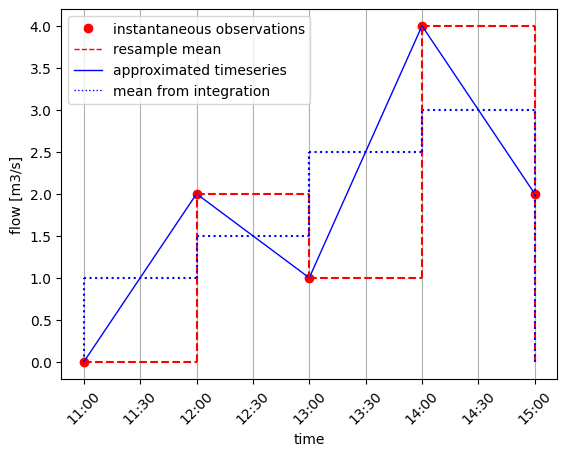

In [9]:
fig,ax = plt.subplots(1,1)
ax.plot(df0['data'], marker='o', markeredgecolor='r',markerfacecolor='r',linestyle='')

# horizontal lines
for ix in range(len(df0)-1):
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].data, df0.iloc[ix+1].data], fmt='-', color='b', lw=1)
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].integrate_mean, df0.iloc[ix].integrate_mean], fmt=':', color='b')

# vertical lines
for ix in range(len(df0)):
    if ix == 0: # left edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix].integrate_mean], fmt=':', color='b')
    elif ix == len(df0)-1: # right edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix-1].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix-1].integrate_mean], fmt=':', color='b')
    else: # middle sections
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].integrate_mean, df0.iloc[ix].integrate_mean], fmt=':', color='b')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].integrate_mean, df0.iloc[ix+1].integrate_mean], fmt=':', color='b')
    
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

ax.grid(axis='x');
plt.xticks(rotation=45);
plt.xlabel('time');
plt.ylabel('flow [m3/s]');

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='r',markerfacecolor='r',linestyle='', 
                          label='instantaneous observations'),
                   Line2D([0], [0], color='r', linestyle='--', lw=1, label='resample mean'),
                   Line2D([0], [0], color='b', linestyle='-',  lw=1, label='approximated timeseries'),
                   Line2D([0], [0], color='b', linestyle=':', lw=1, label='mean from integration')
                   ]
plt.legend(handles=legend_elements);

### Test case 1 - regularly spaced data, data start at 11.30, no gaps

In [8]:
# Create a test df
date_s = pd.to_datetime('2000-01-01 11:30')
date_e = date_s + timedelta(hours=1)
hours = pd.date_range(date_s, date_e, freq='15min')
data  = np.array([3,4,3,1,0])
df1 = pd.DataFrame({'time': hours, 'data': data})
df1 = df1.set_index('time')

In [9]:
df1_o, df1_H = resample_arbitrary_flux_observations_to_hourly(df1, keep_tmp_col=True)

In [10]:
# Compare against known (manual) solutions:
# 1. We have 5 timestamps and thus 4 integrals between these.
# 2. The integrals are in order: 3150, 3150, 1800, 450 // These should be in the 'volume_between_now_and_next' column of df1_o
# 3. The integrals sum to: 8550 // This should be in the 'volume_between_now_and_next' column of df1_H
# 4. We will get an extra final entry in both df1_o and df1_H, which we can ignore. These entries fill in space in the dataframe
#    behind the final timestamp, i.e. the most right-hand value of the integrals. This will have been used to compute integral 4
assert (df1_o['volume_between_now_and_next'].values[:-1] == np.array([3150,3150,1800,450])).all()
assert (df1_H['volume_between_now_and_next'].values[0]   == 8550)

In [11]:
df1

,data
time,
2000-01-01 11:30:00,3
2000-01-01 11:45:00,4
2000-01-01 12:00:00,3
2000-01-01 12:15:00,1
2000-01-01 12:30:00,0


In [12]:
df1_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 11:30:00,3,1,0.0,3150.0
2000-01-01 11:45:00,4,1,900.0,3150.0
2000-01-01 12:00:00,3,1,1800.0,1800.0
2000-01-01 12:15:00,1,1,2700.0,450.0
2000-01-01 12:30:00,0,1,3600.0,NaN


In [13]:
df1_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 12:00:00,2.375,4.0,5400.0,8550.0,4.0,1


### Test case 2 - regularly spaced data, data start at 11.45, no gaps
We'll create a similar dataframe to test case 1 but longer, which we'll use to compare the outcomes of the second dataframe to. The first hour should be different, the other hours should be the same.

In [14]:
# Create a baseline df
date_s = pd.to_datetime('2000-01-01 11:30')
date_e = date_s + timedelta(hours=5)
hours = pd.date_range(date_s, date_e, freq='15min')
data  = np.array([3,4,3,1,0,3,4,3,1,0,3,4,3,1,0,3,4,3,1,0,3])
df2_base = pd.DataFrame({'time': hours, 'data': data})
df2_base = df2_base.set_index('time')

In [15]:
# Create a test dataframe by removing the first entry of the baseline df
df2_test = df2_base.iloc[1:].copy()

In [16]:
_,df2_base_H = resample_arbitrary_flux_observations_to_hourly(df2_base, keep_tmp_col=True)
_,df2_test_H = resample_arbitrary_flux_observations_to_hourly(df2_test, keep_tmp_col=True)

In [17]:
# Compare known solutions:
# 1. We know all but the first entry are identical
assert  df2_base_H['data'].values[0]  != df2_test_H['data'].values[0]
assert (df2_base_H['data'].values[1:] == df2_test_H['data'].values[1:]).all()

In [18]:
df2_base_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 12:00:00,2.375,4.0,5400.0,8550.0,4.0,1
2000-01-01 13:00:00,2.625,4.0,19800.0,9450.0,4.0,1
2000-01-01 14:00:00,2.250,4.0,34200.0,8100.0,4.0,1
2000-01-01 15:00:00,1.875,4.0,48600.0,6750.0,4.0,1
2000-01-01 16:00:00,1.875,4.0,63000.0,6750.0,4.0,1


In [19]:
df2_test_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 12:00:00,1.500,3,2700.0,5400.0,4.0,1
2000-01-01 13:00:00,2.625,4,16200.0,9450.0,4.0,1
2000-01-01 14:00:00,2.250,4,30600.0,8100.0,4.0,1
2000-01-01 15:00:00,1.875,4,45000.0,6750.0,4.0,1
2000-01-01 16:00:00,1.875,4,59400.0,6750.0,4.0,1


### Test case 3 - irregularly space data, no gaps
This is intended to check two things:
1. Does the approach work with irregularly spaced data?
2. Does the approach work if we don't have observations on the precise moments that are the left and right-hand side of the hourly intervals we want to convert to?

In [20]:
time = [pd.to_datetime('2000-01-01 11:30'),
        pd.to_datetime('2000-01-01 11:40'),
        pd.to_datetime('2000-01-01 11:57'),
        pd.to_datetime('2000-01-01 12:03'),
        pd.to_datetime('2000-01-01 12:35')]
data = np.array([0,2,1,4,2])
df3  = pd.DataFrame({'time': time, 'data': data})
df3  = df3.set_index('time')

In [21]:
df3_o,df3_H = resample_arbitrary_flux_observations_to_hourly(df3, keep_tmp_col=True)

In [22]:
# Compare against known (manual) solutions:
# 1. We have 5 timestamps and will add 2 (12:00, 12:30) and thus will have 6 integrals between these.
# 2. The integrals are in order: 600, 1530, 315, 585, 5113.125, 646.875 // 'volume_between_now_and_next' column of df3_o
# 3. The integrals sum to: 8143.125 // This should be in the 'volume_between_now_and_next' column of df3_H
# 4. We will get an extra final entry in both df1_o and df1_H, which we can ignore. These entries fill in space in the dataframe
#    behind the final timestamp, i.e. the most right-hand value of the integrals. This will have been used to compute integral 4
assert (df3_o['volume_between_now_and_next'].values[:-1] == np.array([600,1530,315,585,5113.125,646.875])).all()
assert (df3_H['volume_between_now_and_next'].values[0]   == 8143.125)

In [23]:
df3

,data
time,
2000-01-01 11:30:00,0
2000-01-01 11:40:00,2
2000-01-01 11:57:00,1
2000-01-01 12:03:00,4
2000-01-01 12:35:00,2


In [24]:
df3_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 11:30:00,0.0000,1.0,0.0,600.000
2000-01-01 11:40:00,2.0000,1.0,600.0,1530.000
2000-01-01 11:57:00,1.0000,1.0,1620.0,315.000
2000-01-01 12:00:00,2.5000,NaN,1800.0,585.000
2000-01-01 12:03:00,4.0000,1.0,1980.0,5113.125
2000-01-01 12:30:00,2.3125,NaN,3600.0,646.875
2000-01-01 12:35:00,2.0000,1.0,3900.0,NaN


In [25]:
df3_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 12:00:00,2.261979,4.0,6000.0,8143.125,3.0,1


### Test case 4 - irregularly space data, gaps
We want to retain the gaps if we have no observations for a given hour, so that we don't create a false sense of security in our interpolated data. This can only occur if we have no observations on the left and right-hand side of the hourly interval (e.g. 11.30 and 12.30), and nothing in between those. 

A second question brought up by such a case is how to handle cases where we have no value at the left or right-hand side of the hourly interval, and nothing to use for interpolation with an earlier value. For example (`time`: `data`):
- 10.30: 1
- 11.00: `to be determined`
- 11.15: 1
- 11.30: n/a
- 12.00: `to be determined`
- 12.30: n/a
- 12.45: 10
- 13.00: `to be determined`
- 13.30: 10

In this case we cannot determine a value for `12.00` because there is no single data point within that interval. To handle the other cases (right-hand side of the `11.00` value, and left-hand side of the `13.00` value), we'll extend the respective values forward and backward as the safest option. 

In [26]:
time = [pd.to_datetime('2000-01-01 10:30'),
        pd.to_datetime('2000-01-01 11:15'), # Data gap: no observations within the 11:30-12:30 window
        pd.to_datetime('2000-01-01 12:45'),
        pd.to_datetime('2000-01-01 13:30')] 
data = np.array([1,1,10,10])
df4  = pd.DataFrame({'time': time, 'data': data})
df4  = df4.set_index('time')

In [27]:
df4_o,df4_H = resample_arbitrary_flux_observations_to_hourly(df4, keep_tmp_col=True)

In [28]:
# Compare against known (manual) solutions:
# 1. We have 4 timestamps and will add 5 more (11:00, 11:30, 12:00, 12:30, 13:00) for a total of 11
# 2. We want to end up with the following mean hourly flows: [11:00 - 1.0], [12:00 - undefined], [13:00 - 10.0]
assert df4_H['data'].values[0] == 1
assert np.isnan(df4_H['data'].values[1]) # NaN == NaN is False by definition, so need to use a dedicated function to checl
assert df4_H['data'].values[2] == 10

In [29]:
df4

,data
time,
2000-01-01 10:30:00,1
2000-01-01 11:15:00,1
2000-01-01 12:45:00,10
2000-01-01 13:30:00,10


In [30]:
df4_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 10:30:00,1.0,1.0,0.0,1800.0
2000-01-01 11:00:00,1.0,NaN,1800.0,900.0
2000-01-01 11:15:00,1.0,1.0,2700.0,900.0
2000-01-01 11:30:00,1.0,NaN,3600.0,5850.0
2000-01-01 12:00:00,5.5,NaN,5400.0,13950.0
2000-01-01 12:30:00,10.0,NaN,7200.0,9000.0
2000-01-01 12:45:00,10.0,1.0,8100.0,9000.0
2000-01-01 13:00:00,10.0,NaN,9000.0,18000.0
2000-01-01 13:30:00,10.0,1.0,10800.0,NaN


In [31]:
df4_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 11:00:00,1.0,2.0,4500.0,3600.0,1.0,1
2000-01-01 12:00:00,NaN,0.0,9000.0,19800.0,0.0,0
2000-01-01 13:00:00,10.0,1.0,24300.0,36000.0,2.0,1


### Test case 5 - data gaps, with the single hourly value on the right-hand side of the summing interval
In this case, we do want to keep the estimated hourly flow rate because there is at least one valid value in the interval (even if it is as far right on the interval as possible). 

In [32]:
time = [pd.to_datetime('2000-01-01 10:30'),
        pd.to_datetime('2000-01-01 11:15'), # Data gap: no observations within the 11:30-12:30 window
        pd.to_datetime('2000-01-01 12:30')]
data = np.array([1,1,10])
df5  = pd.DataFrame({'time': time, 'data': data})
df5  = df5.set_index('time')

In [33]:
df5_o, df5_H = resample_arbitrary_flux_observations_to_hourly(df5, keep_tmp_col=True)

In [34]:
# We should have values for both 11:00 and 12:00
assert (df5_H['data'] > 0).all()

In [35]:
df5

,data
time,
2000-01-01 10:30:00,1
2000-01-01 11:15:00,1
2000-01-01 12:30:00,10


In [36]:
df5_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 10:30:00,1.0,1.0,0.0,1800.0
2000-01-01 11:00:00,1.0,NaN,1800.0,900.0
2000-01-01 11:15:00,1.0,1.0,2700.0,1710.0
2000-01-01 11:30:00,2.8,NaN,3600.0,8280.0
2000-01-01 12:00:00,6.4,NaN,5400.0,14760.0
2000-01-01 12:30:00,10.0,1.0,7200.0,NaN


In [37]:
df5_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next,is_obs_RHS,based_on_obs
2000-01-01 11:00:00,1.225,2.0,4500.0,4410.0,1.0,1
2000-01-01 12:00:00,6.400,0.0,9000.0,23040.0,1.0,1


### Test case 6 - real data

In [38]:
data_path = 'C:/Globus endpoint/CAMELS_spat/camels-spat-data/basin_data/USA_14400000/observations/USA_14400000_flow_observations_raw.csv'

In [39]:
# Read only the columns we need (time and obs)
raw = pd.read_csv(data_path, index_col=0, parse_dates=True, usecols=['tz_datetime','obs_00060'])

In [40]:
raw_o,raw_H = resample_arbitrary_flux_observations_to_hourly(raw, data='obs_00060')

In [41]:
raw_H

,obs_00060,based_on_obs
1988-10-01 08:00:00,77.00,1
1988-10-01 09:00:00,76.50,1
1988-10-01 10:00:00,75.00,1
1988-10-01 11:00:00,75.00,1
1988-10-01 12:00:00,75.00,1
...,...,...
2023-01-03 03:00:00,4298.75,1
2023-01-03 04:00:00,4260.00,1
2023-01-03 05:00:00,4258.75,1
2023-01-03 06:00:00,4218.75,1


<Axes: >

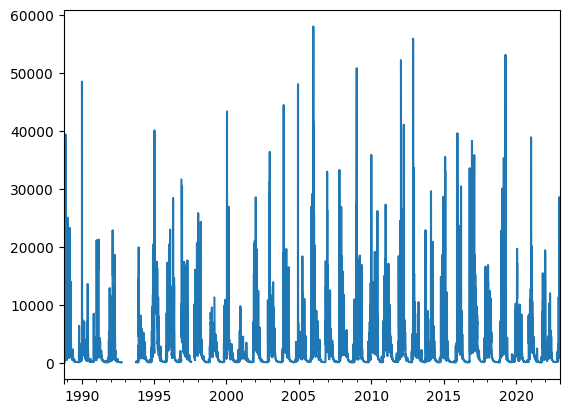

In [42]:
raw_H['obs_00060'].plot()

<Axes: xlabel='tz_datetime'>

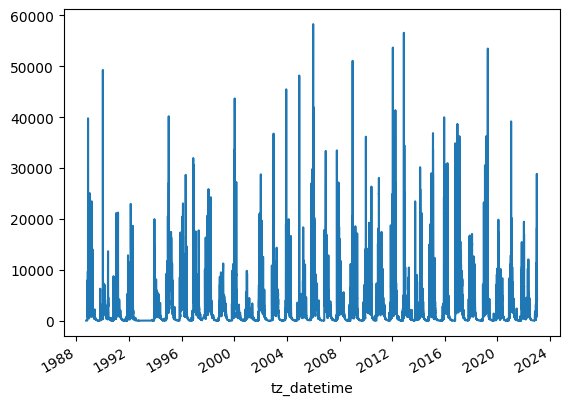

In [43]:
raw['obs_00060'].plot()

### Test case 7 - real data with `Ice` values and quality flag handling

In [44]:
data_path = 'C:/Globus endpoint/CAMELS_spat/camels-spat-data/basin_data/USA_01013500/observations/USA_01013500_flow_observations_raw.csv'

In [45]:
# Read only the columns we need (time, obs, quality)
raw = pd.read_csv(data_path, index_col=0, parse_dates=True, usecols=['tz_datetime','obs_00060','obs_00060_cd'], 
                  low_memory=False)

In [46]:
# Create a temporary dataframe where we replace any "Ice" values in flow obs with NaN
tmp = raw.copy()

In [47]:
tmp['obs_00060'] = tmp['obs_00060'].replace('Ice',np.nan).astype('float')

In [48]:
tmp = tmp.drop(columns={'obs_00060_cd'}) # remove the QC column

In [49]:
# Hourly estimates, based on tmp dataframe (where we have only floats in Qobs)
_,raw_H = resample_arbitrary_flux_observations_to_hourly(tmp, data='obs_00060')

In [50]:
assert (raw_H['obs_00060'] >= 0).sum() == (raw_H['based_on_obs'] == 1).sum() # Are all Qobs values based on observations?

In [54]:
# Assign the quality flags
assign_hourly_quality_flag(raw, raw_H, 'USA', center_window=True)

,obs_00060,based_on_obs,is_ice_affected,minimum_data_quality
1990-10-01 05:00:00,350.000,1,0,A:[91]
1990-10-01 06:00:00,721.125,1,0,A:[91]
1990-10-01 07:00:00,749.125,1,0,A:[91]
1990-10-01 08:00:00,771.125,1,0,A:[91]
1990-10-01 09:00:00,787.000,1,0,A:[91]
...,...,...,...,...
2023-01-03 00:00:00,2800.000,1,0,P
2023-01-03 01:00:00,2800.000,1,0,P
2023-01-03 02:00:00,2808.750,1,0,P
2023-01-03 03:00:00,2820.000,1,0,P


In [66]:
data_path = 'C:/Globus endpoint/CAMELS_spat/camels-spat-data/basin_data/USA_01022500/observations/USA_01022500_flow_observations_raw.csv'

In [67]:
# Read only the columns we need (time, obs, quality)
raw = pd.read_csv(data_path, index_col=0, parse_dates=True, usecols=['tz_datetime','obs_00060','obs_00060_cd'], 
                  low_memory=False)

In [68]:
# Create a temporary dataframe where we replace any "Ice" values in flow obs with NaN
tmp = raw.copy()

In [69]:
tmp['obs_00060'] = tmp['obs_00060'].replace('Ice',np.nan).astype('float')

In [70]:
tmp = tmp.drop(columns={'obs_00060_cd'}) # remove the QC column

In [71]:
# Hourly estimates, based on tmp dataframe (where we have only floats in Qobs)
_,raw_H = resample_arbitrary_flux_observations_to_hourly(tmp, data='obs_00060')

In [74]:
# Assign the quality flags
raw_H = assign_hourly_quality_flag(raw, raw_H, 'USA', center_window=True)

### DEV - find USGS data quality flags in downloaded data

In [117]:
cs_meta = pd.read_csv('C:/Globus endpoint/CAMELS_spat/camels-spat-data/camels_spat_metadata.csv')
cs_nope = pd.read_csv('C:/Globus endpoint/CAMELS_spat/camels-spat-data/camels_spat_unusable.csv', dtype={'Station_id': str})

In [124]:
basins_path = Path('C:/Globus endpoint/CAMELS_spat/camels-spat-data')

In [130]:
# Find which data quality flags we are dealing with
all_flags = []
for ix,row in cs_meta.iterrows():
    if row.Country == 'USA' and row.Station_id not in cs_nope['Station_id'].values:
        site, _, _, csv_path, _, _ = cs.prepare_flow_download_outputs(cs_meta, ix, basins_path)
        tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])
        all_flags.append(tmp['obs_00060_cd'].unique())
        print(f'{ix: >3}. Now working on {site}')

1027. Now working on 01013500
1028. Now working on 01022500
1029. Now working on 01030500
1030. Now working on 01031500
1031. Now working on 01047000


C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_10632\4180838043.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])


1032. Now working on 01052500
1033. Now working on 01054200
1034. Now working on 01055000
1035. Now working on 01057000
1036. Now working on 01073000
1037. Now working on 01078000
1038. Now working on 01118300
1039. Now working on 01121000
1040. Now working on 01123000
1041. Now working on 01134500
1042. Now working on 01137500
1043. Now working on 01139000
1044. Now working on 01139800
1045. Now working on 01142500
1046. Now working on 01144000
1047. Now working on 01162500
1048. Now working on 01169000
1049. Now working on 01170100
1050. Now working on 01181000
1051. Now working on 01187300
1052. Now working on 01195100
1053. Now working on 01333000
1054. Now working on 01350000
1055. Now working on 01350080
1056. Now working on 01350140
1057. Now working on 01365000
1058. Now working on 01411300
1059. Now working on 01413500
1060. Now working on 01414500
1061. Now working on 01415000
1062. Now working on 01423000
1063. Now working on 01434025
1064. Now working on 01435000
1065. Now 

1308. Now working on 04216418
1309. Now working on 04221000
1310. Now working on 04224775
1312. Now working on 04256000
1313. Now working on 04296000
1314. Now working on 05056000
1315. Now working on 05057000
1316. Now working on 05057200
1317. Now working on 05062500
1318. Now working on 05087500
1319. Now working on 05120500
1320. Now working on 05123400
1321. Now working on 05129115
1322. Now working on 05131500
1323. Now working on 05291000
1324. Now working on 05362000
1325. Now working on 05393500
1326. Now working on 05399500
1327. Now working on 05408000
1328. Now working on 05412500
1329. Now working on 05413500
1330. Now working on 05414000
1331. Now working on 05444000
1332. Now working on 05454000
1333. Now working on 05458000
1334. Now working on 05466500
1335. Now working on 05487980
1336. Now working on 05488200
1337. Now working on 05489000
1338. Now working on 05495000
1339. Now working on 05495500
1340. Now working on 05501000
1341. Now working on 05503800
1342. Now 

1583. Now working on 11224500
1586. Now working on 11253310
1587. Now working on 11264500
1588. Now working on 11266500
1589. Now working on 11274500
1590. Now working on 11274630
1591. Now working on 11284400
1592. Now working on 11299600
1593. Now working on 11381500
1594. Now working on 11383500
1595. Now working on 11451100
1596. Now working on 11468500
1597. Now working on 11473900
1598. Now working on 11475560
1599. Now working on 11476600
1600. Now working on 11478500
1601. Now working on 11480390
1602. Now working on 11481200
1603. Now working on 11482500
1604. Now working on 11522500
1605. Now working on 11523200
1606. Now working on 11528700
1607. Now working on 11532500
1608. Now working on 12010000
1609. Now working on 12013500
1610. Now working on 12020000
1611. Now working on 12025000
1612. Now working on 12025700
1613. Now working on 12035000
1614. Now working on 12040500
1615. Now working on 12041200
1616. Now working on 12043000
1617. Now working on 12048000
1618. Now 

C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_10632\4180838043.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])


1648. Now working on 12414500
1649. Now working on 12447390
1650. Now working on 12451000
1651. Now working on 12488500
1652. Now working on 13011500
1653. Now working on 13011900
1654. Now working on 13018300
1655. Now working on 13023000
1656. Now working on 13083000
1657. Now working on 13161500
1658. Now working on 13235000
1659. Now working on 13240000
1660. Now working on 13310700
1661. Now working on 13313000
1662. Now working on 13331500


C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_10632\4180838043.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])


1663. Now working on 13337000
1664. Now working on 13338500


C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_10632\4180838043.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])


1665. Now working on 13340000


C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_10632\4180838043.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_path, usecols=['obs_00060_cd'])


1666. Now working on 13340600
1667. Now working on 14020000
1668. Now working on 14092750
1669. Now working on 14096850
1670. Now working on 14137000
1671. Now working on 14138800
1672. Now working on 14138870
1673. Now working on 14138900
1674. Now working on 14139800
1675. Now working on 14141500
1676. Now working on 14154500
1677. Now working on 14158500
1678. Now working on 14158790
1679. Now working on 14166500
1680. Now working on 14182500
1681. Now working on 14185000
1682. Now working on 14185900
1683. Now working on 14187000
1684. Now working on 14216500
1685. Now working on 14222500
1686. Now working on 14236200
1687. Now working on 14301000
1688. Now working on 14303200
1689. Now working on 14305500
1690. Now working on 14306340
1691. Now working on 14306500
1692. Now working on 14308990
1693. Now working on 14309500
1694. Now working on 14316700
1695. Now working on 14325000
1696. Now working on 14362250
1697. Now working on 14400000


In [135]:
# Convert to a flat list
all_flags_list = [l.tolist() for l in all_flags]
all_flags_list =  [item for sublist in all_flags_list for item in sublist]

In [137]:
# Find unique values
set(all_flags_list)

{'A',
 'A:<',
 'A:>',
 'A:R',
 'A:[0]',
 'A:[4]',
 'A:[90]',
 'A:[91]',
 'A:[92]',
 'A:[93]',
 'A:e',
 'P',
 'P:e',
 nan,
 nan}

In [144]:
# Find which station index we have for the flags we need to double-check
for i,sublist in enumerate(all_flags):
    for item in sublist.tolist():
        if item == 'A:[0]':
            print(f'A:[0] in {i}')
        if item == 'A:[4]':
            print(f'A:[4] in {i}')
        if item == 'A:[90]':
            print(f'A:[90] in {i}')

A:[4] in 16
A:[90] in 25
A:[90] in 71
A:[90] in 75
A:[90] in 83
A:[90] in 87
A:[90] in 88
A:[90] in 101
A:[90] in 102
A:[90] in 110
A:[90] in 114
A:[90] in 115
A:[90] in 118
A:[0] in 123
A:[0] in 124
A:[90] in 126
A:[0] in 126
A:[90] in 127
A:[90] in 140
A:[90] in 142
A:[90] in 145
A:[90] in 150
A:[90] in 151
A:[90] in 153
A:[90] in 155
A:[90] in 156
A:[90] in 157
A:[0] in 178
A:[90] in 207
A:[90] in 218
A:[90] in 220
A:[0] in 220
A:[90] in 225
A:[90] in 226
A:[90] in 227
A:[0] in 228
A:[90] in 231
A:[90] in 232
A:[90] in 234
A:[90] in 235
A:[90] in 253
A:[0] in 282
A:[90] in 289
A:[90] in 290
A:[90] in 302
A:[90] in 306
A:[90] in 311
A:[90] in 312
A:[90] in 313
A:[90] in 317
A:[90] in 319
A:[90] in 320
A:[90] in 321
A:[90] in 322
A:[90] in 323
A:[90] in 324
A:[0] in 324
A:[90] in 338
A:[90] in 340
A:[90] in 343
A:[90] in 344
A:[90] in 345
A:[90] in 346
A:[90] in 351
A:[90] in 352
A:[90] in 353
A:[90] in 356
A:[90] in 357
A:[90] in 360
A:[90] in 362
A:[90] in 363
A:[90] in 374
A:[90] i

In [147]:
# Find station name of an index listed in previous cell, so that we know which header file to look at for the flag description
cs_meta.iloc[123+1027]

Country                                                                  USA
Station_id                                                          02112120
Station_name                            ROARING RIVER NEAR ROARING RIVER, NC
Station_lat                                                         36.25028
Station_lon                                                        -81.04444
Station_source                                                     CAMELS-US
Outlet_lat                                                            -999.0
Outlet_lon                                                            -999.0
Outlet_source                                                            NaN
Mapped_lat                                                         36.250277
Mapped_lon                                                        -81.044443
Manual_lat                                                            -999.0
Manual_lon                                                            -999.0